### helper functions

In [ ]:
import logging

# Configure global logging format
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True
)

LOGGER = logging.getLogger('Starfysh')

In [ ]:
def preprocess(adata_raw,
               lognorm=True,
               min_perc=None,
               max_perc=None,
               n_top_genes=6000,
               mt_thld=100,
               verbose=True,
               multiple_data=False
               ):
    """
    Preprocessing ST gexp matrix, remove Ribosomal & Mitochondrial genes
    Parameters
    ----------
    adata_raw : annData
        Spot x Bene raw expression matrix [S x G]
    min_perc : float
        lower-bound percentile of non-zero gexps for filtering spots
    max_perc : float
        upper-bound percentile of non-zero gexps for filtering spots
    n_top_genes: float
        number of the variable genes
    mt_thld : float
        max. percentage of mitochondrial gexps for filtering spots
        with excessive MT expressions
    multiple_data: bool
        whether the study need integrate datasets
    """
    adata = adata_raw.copy()

    if min_perc and max_perc:
        assert 0 < min_perc < max_perc < 100, \
            "Invalid thresholds for cells: {0}, {1}".format(min_perc, max_perc)
        min_counts = np.percentile(adata.obs['total_counts'], min_perc)
        sc.pp.filter_cells(adata, min_counts=min_counts)

    # Remove cells with excessive MT expressions
    # Remove MT & RB genes

    if verbose:
        LOGGER.info('Preprocessing1: delete the mt and rp')
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['rb'] = np.logical_or(
        adata.var_names.str.startswith('RPS'),
        adata.var_names.str.startswith('RPL')
    )

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
    mask_cell = adata.obs['pct_counts_mt'] < mt_thld
    mask_gene = np.logical_and(~adata.var['mt'], ~adata.var['rb'])

    adata = adata[mask_cell, mask_gene]
    sc.pp.filter_genes(adata, min_cells=1)

    if lognorm:
        if verbose:
            LOGGER.info('Preprocessing2: Normalize')
        if multiple_data:
            sc.pp.normalize_total(adata, target_sum=1e6, inplace=True)
        else:
            sc.pp.normalize_total(adata, inplace=True)

        # Preprocessing3: Logarithm
        if verbose:
            LOGGER.info('Preprocessing3: Logarithm')
        sc.pp.log1p(adata)
    else:
        if verbose:
            LOGGER.info('Skip Normalize and Logarithm')

    # Preprocessing4: Find the variable genes
    if verbose:
        LOGGER.info('Preprocessing4: Find the variable genes')
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=n_top_genes, inplace=True)

    return adata

In [ ]:
def load_adata(data_folder, sample_id, n_genes, multiple_data=False):
    """
    load visium adata with raw counts, preprocess & extract highly variable genes
    Parameters
    ----------
        data_folder : str
            Root directory of the data
        sample_id : str
            Sample subdirectory under `data_folder`
        n_genes : int
            the number of the gene for training
        multiple_data: bool
            whether the study include multiple datasets
    Returns
    -------
        adata : sc.AnnData
            Processed ST raw counts
        adata_norm : sc.AnnData
            Processed ST normalized & log-transformed data
    """
    has_feature_h5 = os.path.isfile(
        os.path.join(data_folder, sample_id, 'filtered_feature_bc_matrix.h5')
    ) # whether dataset stored in h5 with spatial info.

    if has_feature_h5:
        adata = sc.read_visium(path=os.path.join(data_folder, sample_id), library_id=sample_id)
        adata.var_names_make_unique()
        adata.obs['sample'] = sample_id
    elif sample_id.startswith('simu'): # simulations
        adata = sc.read_csv(os.path.join(data_folder, sample_id, 'counts.st_synth.csv'))
    else:
        filenames = [
            f[:-5] for f in os.listdir(os.path.join(data_folder, sample_id))
            if f[-5:] == '.h5ad'
        ]
        assert len(filenames) == 1, \
            "None or more than `h5ad` file in the data directory," \
            "please contain only 1 target ST file in the given directory"
        adata = sc.read_h5ad(os.path.join(data_folder, sample_id, filenames[0] + '.h5ad'))
        adata.var_names_make_unique()
        adata.obs['sample'] = sample_id

    if '_index' in adata.var.columns:
        adata.var_names = adata.var['_index']
        adata.var_names.name = 'Genes'
        adata.var.drop('_index', axis=1, inplace=True)

    adata_norm = preprocess(adata, n_top_genes=n_genes,multiple_data=multiple_data)
    adata = adata[:, list(adata_norm.var_names)]
    adata.var['highly_variable'] = adata_norm.var['highly_variable']
    adata.obs = adata_norm.obs

    return adata, adata_norm

# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data.

**Background:**

Spatial transcriptomics technologies are currently limited, because their resolution is limited to niches (spots) of sizes well beyond that of a single cell. Although several pipelines proposed joint analysis with single-cell RNA-sequencing (scRNA-seq) to alleviate this problem they are limited to a discrete view of cell type proportion inside every spot. This limitation becomes critical in the common case where, even within a cell type, there is a continuum of cell states. We present *Deconvolution of Spatial Transcriptomics profiles using Variational Inference (DestVI)*, a probabilistic method for multi-resolution analysis for spatial transcriptomics that explicitly models continuous variation within cell types.

**Plan for this tutorial:**

1. Loading the data
1. Training the single-cell model (scLVM) to learn a basis of gene expression on the scRNA-seq data
1. Training the spatial model (stLVM) to perform the deconvolution
1. Visualize the learned cell type proportions
1. Run our automated pipeline
1. Dig into the intra cell type information
1. Run cell-type specific differential expression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


[2023-03-16 23:28:33] Created a temporary directory at /tmp/tmpqdcwcn_n
[2023-03-16 23:28:33] Writing /tmp/tmpqdcwcn_n/_remote_module_non_scriptable.py
[2023-03-16 23:28:33] Global seed set to 0
[2023-03-16 23:28:35] NumExpr defaulting to 2 threads.
/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
# !pip install 'matplotlib<3.7'

In [ ]:
import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from scvi.model import CondSCVI, DestVI

import pandas as pd
import os
from scipy.io import mmread

# forces GPU use
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=float32,force_device=True'

In [ ]:
spatial_path = 'drive/MyDrive/research/Kaylee/benchmarking'
sc_path = 'drive/MyDrive/research/Kaylee/data/CID44971/scrna'
results_folder = 'drive/MyDrive/research/Kaylee/benchmarking/destvi_results'

## Data loading & processing

First, let's load the single-cell data. We profiled immune cells from murine lymph nodes with 10x Chromium, as a control / case study to study the immune response to exposure to a mycobacteria (refer to our paper for more info). We provide the preprocessed data from our reproducibility repository: it contains the raw counts (DestVI always takes raw counts as input).

In [ ]:
# Load cell & gene labels
barcode_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_barcodes.tsv'), 
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE barcode
)

gene_df = pd.read_csv(
    os.path.join(sc_path, 'count_matrix_genes.tsv'),
    delimiter='\t',
    header=None # this file doesn't contain the true "header" (column info), the first row is a TRUE gene
)

print('# cells: {0}, # genes: {1}'.format(len(barcode_df), len(gene_df)))

# Construct adata object for scRNA-seq
barcodes = pd.DataFrame(barcode_df[0].values, index=barcode_df[0].values, columns=['Barcode'])
genes = pd.DataFrame(gene_df[0].values, index=gene_df[0].values, columns=['features'])

cnt = mmread(
    os.path.join(sc_path, 'count_matrix_sparse.mtx')
).toarray()

adata_sc = sc.AnnData(
    X=cnt.T,
    obs=barcodes,
    var=genes
)
print(adata_sc.shape)

# cells: 7986, # genes: 29733


<ipython-input-9-881f8690cfd4>:24: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sc = sc.AnnData(


(7986, 29733)


In [ ]:
meta_df = pd.read_csv(
    os.path.join(sc_path, 'metadata.csv'), index_col=[0], header=[0]
)
meta_df.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major
CID44971_AAGCCGCCACGCATCG,CID44971,3409,1492,9.416251,TNBC,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID44971_AAGGAGCTCAACACAC,CID44971,11133,3386,6.557083,TNBC,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID44971_ACGAGCCTCCGATATG,CID44971,2119,1021,9.815951,TNBC,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID44971_ACGTCAATCCGAAGAG,CID44971,2225,1100,8.089888,TNBC,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID44971_AGAGTGGCACACGCTG,CID44971,10826,3055,4.092001,TNBC,Endothelial ACKR1,Endothelial ACKR1,Endothelial


In [ ]:
adata_sc.obs['celltype_major'] = meta_df['celltype_major']
adata_sc.obs['celltype_minor'] = meta_df['celltype_minor']
adata_sc.obs['celltype_subset'] = meta_df['celltype_subset']
adata_sc.obs

,Barcode,celltype_major,celltype_minor,celltype_subset
CID44971_AAGCCGCCACGCATCG,CID44971_AAGCCGCCACGCATCG,Endothelial,Endothelial ACKR1,Endothelial ACKR1
CID44971_AAGGAGCTCAACACAC,CID44971_AAGGAGCTCAACACAC,Endothelial,Endothelial ACKR1,Endothelial ACKR1
CID44971_ACGAGCCTCCGATATG,CID44971_ACGAGCCTCCGATATG,Endothelial,Endothelial ACKR1,Endothelial ACKR1
CID44971_ACGTCAATCCGAAGAG,CID44971_ACGTCAATCCGAAGAG,Endothelial,Endothelial ACKR1,Endothelial ACKR1
CID44971_AGAGTGGCACACGCTG,CID44971_AGAGTGGCACACGCTG,Endothelial,Endothelial ACKR1,Endothelial ACKR1
...,...,...,...,...
CID44971_TTGACTTTCTCTTATG,CID44971_TTGACTTTCTCTTATG,Normal Epithelial,Mature Luminal,Mature Luminal
CID44971_TTGGCAAGTTCGTCTC,CID44971_TTGGCAAGTTCGTCTC,Normal Epithelial,Mature Luminal,Mature Luminal
CID44971_TTTATGCTCAGATAAG,CID44971_TTTATGCTCAGATAAG,Normal Epithelial,Mature Luminal,Mature Luminal
CID44971_TTTCCTCCAAGCCATT,CID44971_TTTCCTCCAAGCCATT,Normal Epithelial,Mature Luminal,Mature Luminal


In [ ]:
adata_st, adata_st_normed = load_adata(data_folder=spatial_path,  # root data directory
                                       sample_id='simu_defined',  # sample_id
                                       n_genes=2000  # number of highly variable genes to keep
                                      )

[2023-03-16 23:30:37] Preprocessing1: delete the mt and rp
/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
[2023-03-16 23:30:39] Preprocessing2: Normalize
[2023-03-16 23:30:39] Preprocessing3: Logarithm
[2023-03-16 23:30:39] Preprocessing4: Find the variable genes
<ipython-input-3-726b46102734>:50: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['highly_variable'] = adata_norm.var['highly_variable']


In [ ]:
xx, yy = np.meshgrid(np.arange(50), np.arange(50), indexing='ij')
xx, yy = xx.flatten(), yy.flatten()
adata_st.obsm["location"] = np.column_stack((yy, xx))

In [ ]:
adata_st.obsm["location"]

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       ...,
       [47, 49],
       [48, 49],
       [49, 49]])

In [ ]:
sc_adata = adata_sc.copy()
st_adata = adata_st.copy()

We clustered the single-cell data by major immune cell types. DestVI can resolve beyond discrete clusters, but need to work with an existing level of clustering. A rule of thumb to keep in mind while clsutering is that DestVI assumes only a single state from each cell type exists in each spot. For example, resting and inflammed monocytes cannot co-exist in one unique spot according to our assumption. Users may cluster their data so that this modeling assumption is as accurate as possible.

In [ ]:
# visualization of sc data
sc_vis = sc_adata.copy()
sc.pp.normalize_total(sc_vis, target_sum=1e4)
sc.pp.log1p(sc_vis)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'celltype_major' as categorical
... storing 'celltype_minor' as categorical
... storing 'celltype_subset' as categorical
/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


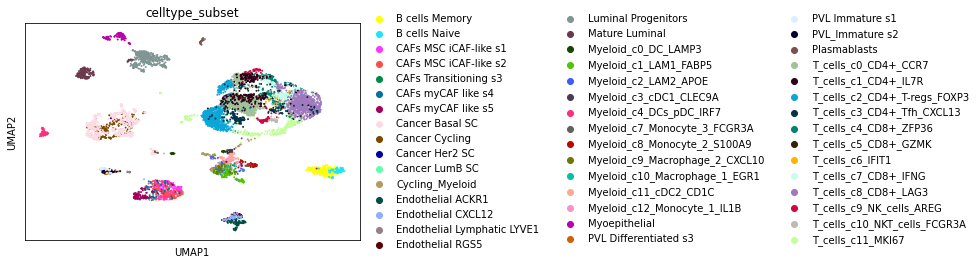

In [ ]:
sc.pp.neighbors(sc_vis, n_neighbors=10, n_pcs=40)
sc.tl.umap(sc_vis)
sc.pl.umap(sc_vis, color="celltype_subset")

In [ ]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Now, let's load the spatial data and choose a common gene subset. Users will note that having a common gene set is a prerequisite of the method.

In [ ]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm["spatial"] = st_adata.obsm["location"]

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [ ]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

In [ ]:
# sc.pl.embedding(st_adata, basis="spatial", s=80)

## Fit the scLVM

In order to learn cell state specific gene expression patterns, we will fit the single-cell Latent Variable Model (scLVM) to single-cell RNA sequencing data from the same tissue.

In [ ]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="celltype_subset")

/usr/local/lib/python3.9/dist-packages/scvi/data/_utils.py:172: UserWarning: Category 9 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.

In [ ]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.2.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'celltype_subset', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 7986  │
│     n_labels     │  46   │
│      n_vars      │ 1751  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                 labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃           Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype_subset'] │         B cells Memory         │          0          │
│                              │         B cells Naive          │          1          │
│                              │     CAFs MSC iCAF-like s1      │          2          │
│                              │     CAFs MSC iCAF-like s2      │          3          │
│                              │     CAFs Transitioning s3      │          4          │
│                              │       CAFs myCAF like s4       │          5          │
│                              │       CAFs myCAF like s5       │          6          │
│                              │        Cancer Basal SC         │          7          │
│                              │         Cancer Cycling         │          8          │
│                              │         Cancer Her2 SC         │          9          │
│                              │         Cancer LumB SC         │         10          │
│                              │        Cycling_Myeloid         │         11          │
│                              │       Endothelial ACKR1        │         12          │
│                              │       Endothelial CXCL12       │         13          │
│                              │  Endothelial Lymphatic LYVE1   │         14          │
│                              │        Endothelial RGS5        │         15          │
│                              │      Luminal Progenitors       │         16          │
│                              │         Mature Luminal         │         17          │
│                              │      Myeloid_c0_DC_LAMP3       │         18          │
│                              │ Myeloid_c10_Macrophage_1_EGR1  │         19          │
│                              │     Myeloid_c11_cDC2_CD1C      │         20          │
│                              │  Myeloid_c12_Monocyte_1_IL1B   │         21          │
│                              │     Myeloid_c1_LAM1_FABP5      │         22          │
│                              │      Myeloid_c2_LAM2_APOE      │         23          │
│                              │     Myeloid_c3_cDC1_CLEC9A     │         24          │
│                              │    Myeloid_c4_DCs_pDC_IRF7     │         25          │
│                              │  Myeloid_c7_Monocyte_3_FCGR3A  │         26          │
│                              │  Myeloid_c8_Monocyte_2_S100A9  │         27          │
│                              │ Myeloid_c9_Macrophage_2_CXCL10 │         28          │
│                              │         Myoepithelial          │         29          │
│                              │     PVL Differentiated s3      │         30          │
│                              │        PVL Immature s1         │         31          │
│                              │        PVL_Immature s2         │         32          │
│                              │          Plasmablasts          │         33          │
│                              │      T_cells_c0_CD4+_CCR7      │         34          │
│                              │  T_cells_c10_NKT_cells_FCGR3A  │         35          │
│                              │       T_cells_c11_MKI67        │         36          │
│                              │      T_cells_c1_CD4+_IL7R      │         37          │
│                              │  T_cells_c2_CD4+_T-regs_FOXP3  │         38          │
│                              │   T_cells_c3_CD4+_Tfh_CXCL13   │         39          │
│                              │     T_cells_c4_CD8+_ZFP36      │         40          │
│                              │      T_

In [ ]:
sc_model.train()

[2023-03-16 23:37:41] GPU available: True (cuda), used: True
[2023-03-16 23:37:41] TPU available: False, using: 0 TPU cores
[2023-03-16 23:37:41] IPU available: False, using: 0 IPUs
[2023-03-16 23:37:41] HPU available: False, using: 0 HPUs
[2023-03-16 23:37:41] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [03:47<00:00,  1.12it/s, loss=492, v_num=1]

[2023-03-16 23:41:29] `Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [03:47<00:00,  1.32it/s, loss=492, v_num=1]


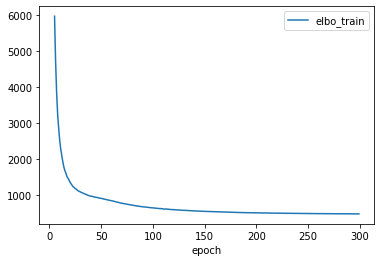

In [ ]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs\<200.

## Deconvolution with stLVM

As a second step, we train our deconvolution model: spatial transcriptomics Latent Variable Model (stLVM).
We setup the DestVI model using the `counts` layer in `st_adata` that contains the raw counts. We then pass the trained `CondSCVI` model and generate a new model based on `st_adata` and `sc_model` using `DestVI.from_rna_model`.

The decoder network architecture will be generated from `sc_model`. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

Potential adaptations of `DestVI.from_rna_model` are:

1. increasing `vamp_prior_p` leads to less gradual changes in gamma values
1. more discretized values. Increasing `l1_sparsity` will lead to sparser results for cell type proportions.
1. Although we recommend using similar sequencing technology for both assays, consider changing `beta_weighting_prior` otherwise.

Technical Note: During inference, we adopt a variational mixture of posterior as a prior to enforce gamma values in stLVM match scLVM (see details in original publication). This empirical prior is based on cell type specific subclustering (using k-means to find `vamp_prior_p` clusters) of the posterior distribution in latent space for every cell.

In [ ]:
DestVI.setup_anndata(st_adata, layer="counts")

In [ ]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.2.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2500  │
│      n_vars      │ 1751  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [ ]:
st_model.train(max_epochs=2500)

[2023-03-16 23:42:24] GPU available: True (cuda), used: True
[2023-03-16 23:42:24] TPU available: False, using: 0 TPU cores
[2023-03-16 23:42:24] IPU available: False, using: 0 IPUs
[2023-03-16 23:42:24] HPU available: False, using: 0 HPUs
[2023-03-16 23:42:24] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [13:21<00:00,  3.47it/s, loss=1.84e+06, v_num=1]

[2023-03-16 23:55:45] `Trainer.fit` stopped: `max_epochs=2500` reached.


Epoch 2500/2500: 100%|██████████| 2500/2500 [13:21<00:00,  3.12it/s, loss=1.84e+06, v_num=1]


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs\<1000.

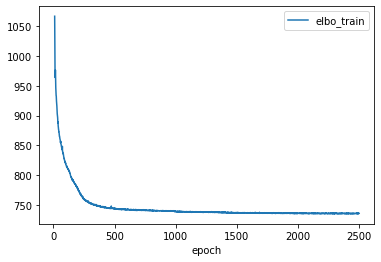

In [ ]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot.

## Cell type proportions

We extract the computed cell type proportions and display them in spatial embedding. These values are directly calculated by normalized the spot-level parameters from the stLVM model.

In [ ]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [ ]:
st_adata.obsm["proportions"].head(5)

,B cells Memory,B cells Naive,CAFs MSC iCAF-like s1,CAFs MSC iCAF-like s2,CAFs Transitioning s3,CAFs myCAF like s4,CAFs myCAF like s5,Cancer Basal SC,Cancer Cycling,Cancer Her2 SC,...,T_cells_c11_MKI67,T_cells_c1_CD4+_IL7R,T_cells_c2_CD4+_T-regs_FOXP3,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c4_CD8+_ZFP36,T_cells_c5_CD8+_GZMK,T_cells_c6_IFIT1,T_cells_c7_CD8+_IFNG,T_cells_c8_CD8+_LAG3,T_cells_c9_NK_cells_AREG
exper0_location_0,2.831830e-09,3.244375e-07,0.165719,0.000029,0.000262,0.065547,0.023634,0.424043,2.496537e-13,1.142904e-13,...,0.000002,1.441829e-13,2.563348e-08,1.421944e-13,6.872861e-14,7.892227e-14,2.042552e-09,3.062668e-03,4.218704e-14,2.566354e-14
exper0_location_1,9.121801e-09,6.442059e-07,0.000758,0.000119,0.000107,0.000154,0.428699,0.334729,5.127796e-14,2.446133e-14,...,0.000002,1.812653e-14,5.506866e-08,2.040642e-14,1.087539e-14,1.051964e-14,4.869221e-06,3.360459e-04,5.074544e-15,2.859152e-15
exper0_location_2,3.655576e-02,6.804255e-03,0.144763,0.003884,0.001758,0.031458,0.305919,0.266257,8.770071e-14,4.640962e-14,...,0.000004,3.347475e-14,2.412456e-08,4.407026e-14,1.750288e-14,1.732449e-14,3.669714e-06,7.830499e-07,1.224093e-14,7.863477e-15
exper0_location_3,6.858220e-02,7.825364e-03,0.002127,0.000351,0.000258,0.000911,0.286345,0.284408,1.678908e-12,9.232633e-13,...,0.029180,8.697310e-13,1.690177e-05,1.204645e-12,6.440464e-13,4.652610e-13,2.564331e-05,4.251199e-02,3.777281e-13,1.918257e-13
exper0_location_4,2.141847e-07,2.253198e-05,0.018905,0.004151,0.063491,0.000917,0.311086,0.313374,3.112239e-14,1.471835e-14,...,0.000010,1.035575e-14,3.085142e-13,2.168073e-14,1.171260e-14,6.695273e-15,3.256557e-06,7.397386e-02,5.916508e-15,1.798955e-15


In [ ]:
st_adata.obsm["proportions"].to_csv(os.path.join(results_folder, "out.csv"))